In [1]:
!pip install casadi

import casadi as ca
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import fastprogress
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 21.8 MB/s eta 0:00:00:00:010:01m


In [2]:
def get_device(cuda_preference=True):
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: False ; cudnn available: False ; num devices: 0
Using device cpu
4 CPUs available


## Solving the optimal control problem

In [3]:
T = 5
dt = 0.5
no_samples_x = 20
no_samples_y = 20
no_samples = no_samples_x*no_samples_y
# no_samples = 100
position_range = (-3,3)
velocity_range = (-1,1)

def sample_initial_states(num_samples, position_range, velocity_range):
    positions = np.random.uniform(low=position_range[0], high=position_range[1], size=(num_samples, 1))
    velocities = np.random.uniform(low=velocity_range[0], high=velocity_range[1], size=(num_samples, 1))
    return np.hstack((positions, velocities))


def grid_initial_states(num_samples_x, num_samples_y, position_range, velocity_range):

    x = np.linspace(position_range[0], position_range[1], num_samples_x)
    y = np.linspace(velocity_range[0], velocity_range[1], num_samples_y)

    xx, yy = np.meshgrid(x, y)
    return np.stack([xx.ravel(), yy.ravel()], axis=1)

# Define system dynamics for single integrator
def dynamics_2D(x, u, dt):
    
    if (isinstance(x, torch.Tensor)):
        p = x[...,0]
        v = x[...,1]
        u = u[...,0]
        
    else:
        p = x[0]
        v = x[1]
        
    p = p + dt*v + 0.5*u*dt**2
    v = v + dt * u
    return [p, v]

# Define running cost
def running_cost(x, u):
    
    if (isinstance(x, torch.Tensor)):
        x = x[...,0]
        u = u[...,0]
    else:
        x = x[0]
        
    #return 0.5 * u**2 + (x - 1.9)*(x - 1.0)*(x - 0.6)*(x + 0.5)*(x + 1.2)*(x + 2.1)
    return 0.5 * u**2 + (x - 2)**2*(x + 2)**2

def solve_ocp(x0, T=T, dt=dt, u_min=-1, u_max=1, threshold=1e-5):
    N = int(T / dt)  # Number of time steps

    # Define CasADi variables
    x = ca.MX.sym('x', 2)
    u = ca.MX.sym('u')
    
    # Define cost function and constraints
    cost = 0
    constraints = []
    
    # Initial state
    x_current = x0

    # List to store control variables
    u_vars = []
    
    # Loop through time steps
    for t in range(N):
        u_var = ca.MX.sym(f'u_{t}')
        cost += running_cost(x_current, u_var)
        pv = dynamics_2D(x_current, u_var, dt)
        x_current = ca.vertcat(*pv)
        constraints.append(x_current)
        u_vars.append(u_var)
    
    # Define optimization problem
    opt_vars = ca.vertcat(*u_vars)
    nlp = {'x': opt_vars, 'f': cost, 'g': ca.vertcat(*constraints)}

    # Solver options to suppress verbose output
    opts = {
        'ipopt': {
            'print_level': 0
        },
        'print_time': False
    }
    
    # Create NLP solver with control input bounds
    solver = ca.nlpsol('solver', 'ipopt', nlp, opts)
    
    # Solve the problem
    sol = solver(lbg=-ca.inf, ubg=ca.inf, lbx=u_min, ubx=u_max)
    
    # Extract the optimal cost and actions
    optimal_cost = sol['f'].full().item()
    optimal_actions = sol['x'].full().flatten()
    
    # Apply thresholding to the optimal actions
    optimal_actions[np.abs(optimal_actions) < threshold] = 0.0
    
    return optimal_cost, optimal_actions

# Function to compute the state trajectory using the optimal actions
def compute_trajectory(x0, optimal_actions, dt=dt):
    x_traj = [x0]
    x_current = x0
    cost = 0
    for u in optimal_actions:
        x_current = dynamics_2D(x_current, u, dt)
        x_traj.append(x_current)
        cost += running_cost(x_current, u)
    return np.array(x_traj), cost

# Generate initial states
initial_states = grid_initial_states(no_samples_x, no_samples_y, position_range, velocity_range)
#initial_states = sample_initial_states(no_samples, position_range, velocity_range)

# Solve OCPs and collect data
data = []
for x0 in initial_states:
    cost_opt, actions_opt = solve_ocp(ca.vertcat(*x0))
    data.append((x0, cost_opt, actions_opt))

# Prepare data for training
states, costs, actions = zip(*data)
states = np.vstack(states)
costs = np.array(costs).reshape(-1, 1)
opt_actions = np.array(actions)
 
# Print collected data
print("Initial states:", states.shape)
print("Optimal costs:", costs.shape)
print("Optimal actions:", opt_actions.shape)


traj, _ = compute_trajectory(states[0], opt_actions[0])

print(traj)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Initial states: (400, 2)
Optimal costs: (400, 1)
Optimal actions: (400, 10)
[[-3.00000000e+00 -1.00000000e+00]
 [-3.37500000e+00 -4.99999996e-01]
 [-3.50000000e+00  8.18845469e-09]
 [-3.37499999e+00  5.00000010e-01]
 [-2.99999999e+00  1.00000000e+00]
 [-2.48418256e+00  1.06326970e+00]
 [-2.07754768e+00  5.63269810e-01]
 [-1.92091264e+00  6.32703664e-02]
 [-1.93283312e+00 -1.10952272e-01]
 [-1.99219094e+00 -1.26479030e-01]
 [-2.05543046e+00 -1.26479030e-01]]


## Preparing the Dataset

In [4]:
# Normalization functions
def normalize(tensor, min_val, max_val):
    return 2 * (tensor - min_val) / (max_val - min_val) - 1

def denormalize(tensor, min_val, max_val):
    return (tensor + 1) * (max_val - min_val) / 2 + min_val

costs = np.array(costs).reshape(-1, 1)  # Shape (N, 1)

# Scaling the states to the range [-1, 1]
min_states = np.min(states, axis=0)
max_states = np.max(states, axis=0)
states_scaled = normalize(states, min_states, max_states)

# Scaling the expected costs to the range [-1, 1]
min_costs = np.min(costs)
max_costs = np.max(costs)
costs_scaled = normalize(costs, min_costs, max_costs)

# Convert to PyTorch tensors
initial_states = torch.FloatTensor(states_scaled)
expected_costs = torch.FloatTensor(costs_scaled)

# Create TensorDataset and DataLoaders
dataset = TensorDataset(initial_states, expected_costs)

# Calculate sizes for splitting
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Randomly split dataset into training and validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
val_loader = DataLoader(val_set, batch_size=10, shuffle=True)

# Print a sample of the scaled expected costs
print("Sample scaled expected costs:", expected_costs[0])

Sample scaled expected costs: tensor([1.])


## The Critic Network

In [5]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x

## Training the Critic Network

In [6]:
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    
    epoch_loss = []
    model.train()

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x.to(device))

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss
    return np.mean(epoch_loss)


def validate(dataloader, model, loss_fn, device, master_bar):
    
    epoch_loss = []
    model.eval()
    
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))
            epoch_loss.append(loss.item())
            
    # Return the mean loss
    return np.mean(epoch_loss)


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, scheduler = None, verbose=False):
    
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses = [],[]
    val_percentage = []

    for epoch in master_bar:
        # Train the model
        epoch_train_loss = train(train_dataloader, optimizer, model, 
loss_function, device, master_bar)
        
        if(scheduler != None):
            scheduler.step()
        
        # Validate the model
        epoch_val_loss = validate(val_dataloader, model,
                                  loss_function, device, master_bar)
        # Save loss
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.10f}, val loss: {epoch_val_loss:.10f}')
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses



def plot(title, label, train_results, val_results, yscale='linear', legend = ['Train results', 'Validation results'], x_axis = None,  save_path=None, extra_pt_label=None):

    
    if(x_axis == None):
        epoch_array = np.arange(len(train_results)) + 1
        train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()

        sns.set(style='ticks')

        plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')


        plt.legend(legend)
        plt.xlabel('Epoch')
        
    else:
        
        train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()

        sns.set(style='ticks')

        plt.plot(x_axis, train_results, x_axis, val_results, linestyle='dashed', marker='o')

        plt.legend(legend)
        plt.xlabel('States')
        
    
    
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

Finished training after 65 seconds.


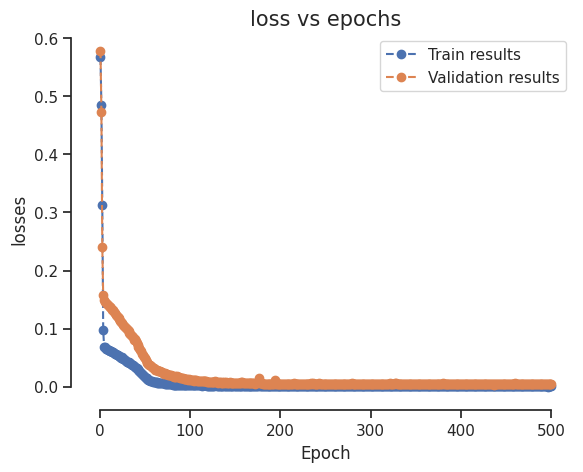

In [7]:
# Initialize network, loss function, and optimizer
critic = Critic().to(device)
loss_function =  nn.MSELoss()
optimizer = optim.Adam(critic.parameters(), lr=1e-4)
#scheduler = StepLR(optimizer, step_size = 10, gamma=0.1, verbose=True)
num_epochs = 500
train_losses, val_losses = run_training(critic, optimizer, loss_function, device, num_epochs, train_loader, val_loader)
plot("loss vs epochs", "losses", train_losses, val_losses)


(400, 1)
(400,)


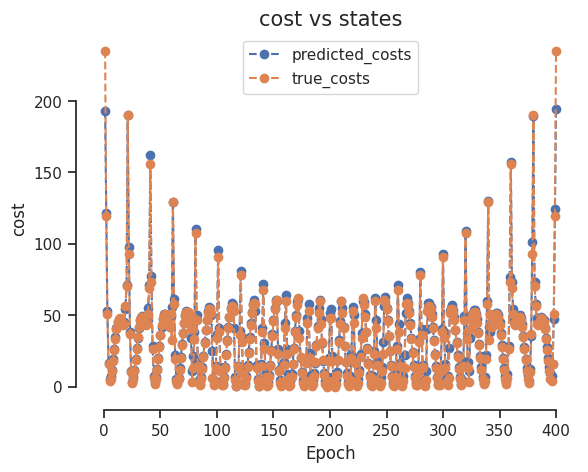

tensor([0.6517], grad_fn=<ViewBackward0>)
tensor([1.])


In [8]:
num_samples_x = 20
num_samples_y = 20

points = grid_initial_states(num_samples_x, num_samples_y, position_range, velocity_range)

critic.eval()
predicted_costs = []
data = []

for x0 in points:
    cost_opt, actions_opt = solve_ocp(ca.vertcat(*x0))
    data.append((cost_opt, actions_opt))
    
    n_x0 = torch.FloatTensor(normalize(x0,min_states,max_states))
    _cost = critic(n_x0.to(device))
    cost = denormalize(_cost, min_costs, max_costs)
    predicted_costs.append(cost.item())

costs, actions = zip(*data)
true_costs = np.array(costs).reshape(-1, 1)

print(true_costs.shape)
print(np.array(predicted_costs).shape)

plot("cost vs states", "cost", predicted_costs, true_costs, legend = ["predicted_costs", "true_costs"])

print(_cost)
print(expected_costs[-1])

## The Actor Network

In [9]:
class LargerActorNetwork(nn.Module):
    def __init__(self):
        super(LargerActorNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 1)
        #self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc5(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc6(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc7(x))
        x = self.fc8(x)
        x = torch.tanh(x)  # Assuming action range is [-1, 1]
        return x


Finished training after 343 seconds.


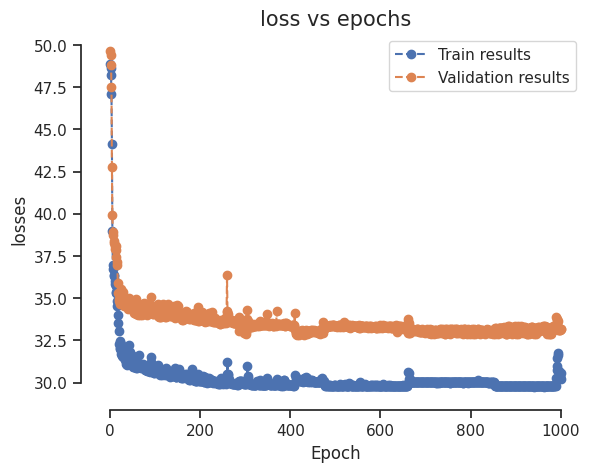

In [10]:
actor = LargerActorNetwork().to(device)
actor.train()
critic.eval()
optimizer = optim.Adam(actor.parameters(), lr=5e-5)
num_epochs = 1000

train_losses = []
val_losses = []

#cost_scaler
#state_scaler
#scaler.inverse_transform(normalized_cost)

start_time = time.time()
    
# Training loop for the actor
for epoch in range(num_epochs):
    actor.train()
    train_loss = 0.0
    for norm_states, _ in train_loader:
        optimizer.zero_grad()
        
        actions = actor(norm_states)
        states = denormalize(norm_states, min_states, max_states)
        
        next_states = torch.stack(dynamics_2D(states, actions, dt)).T
        norm_next_states = normalize(next_states,
                    torch.tensor(min_states), torch.tensor(max_states))
        norm_state_value = critic(norm_next_states.float())
        state_value = denormalize(norm_state_value, min_costs, max_costs)
        
        q_values = running_cost(states, actions) + state_value
        loss = torch.mean(q_values)
   
        loss.backward()
        optimizer.step()
        
        
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation step
    actor.eval()
    val_loss = 0.0
    with torch.no_grad():
        for norm_states, _ in val_loader:
            val_actions = actor(norm_states)
            val_states = denormalize(norm_states, min_states, max_states)
            
            next_states = torch.stack(dynamics_2D(val_states, val_actions, dt)).T
            norm_next_states = normalize(next_states,
                    torch.tensor(min_states), torch.tensor(max_states))
            norm_state_value = critic(norm_next_states.float())
            state_value = denormalize(norm_state_value, min_costs, max_costs)
            
            val_q_values = running_cost(val_states, val_actions) + state_value
            loss = torch.mean(val_q_values)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    #print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')

time_elapsed = np.round(time.time() - start_time, 0).astype(int)
print(f'Finished training after {time_elapsed} seconds.')
plot("loss vs epochs", "losses", train_losses, val_losses)

## Results

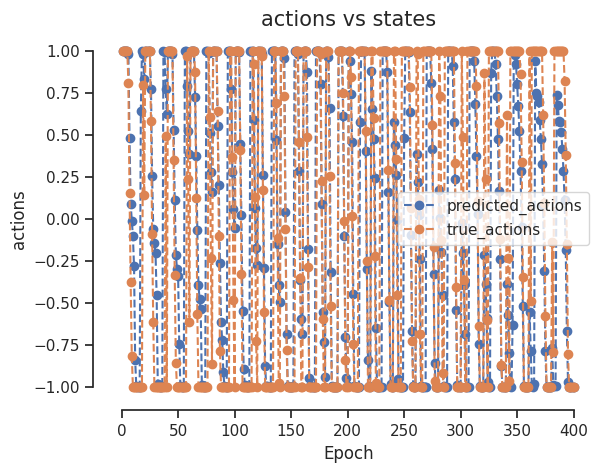

In [11]:
actor.eval()
critic.eval()

predicted_actions = []

for state in initial_states:
    _action = actor(state.to(device))
    predicted_actions.append(_action.item())
    
    
states = denormalize(initial_states, min_states, max_states)
plot("actions vs states", "actions", predicted_actions, opt_actions[:,0], legend = ["predicted_actions", "true_actions"])

Optimal costs: (100, 1)
Optimal actions: (100, 10)


/tmp/ipykernel_33/1831114771.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = actor(torch.tensor(x_current).to(device).float())


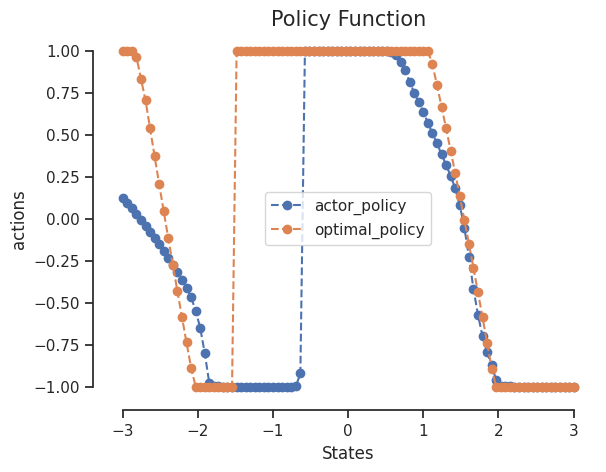

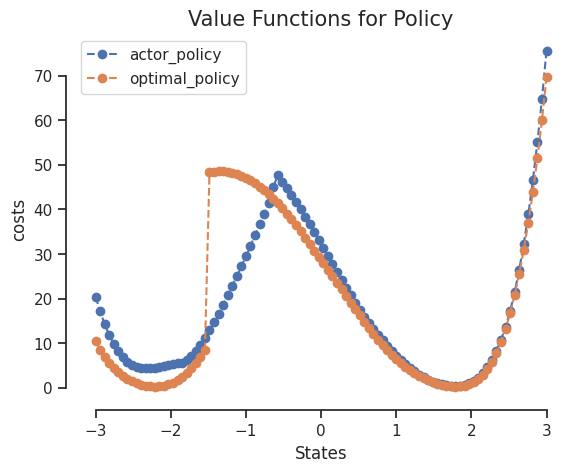

In [12]:
def compute_trajectory_actor(x0,T=T,dt=dt):
    
    N = int(T / dt)
    x_traj = [denormalize(x0, min_states, max_states)]
    x_current = x0
    cost = 0
    for _ in range(N):
        
        with torch.no_grad():
            u = actor(torch.tensor(x_current).to(device).float())
        x_current = denormalize(x_current, min_states, max_states)
        x_current = torch.stack(dynamics_2D(x_current, u, dt))
        x_traj.append(x_current)
        cost += running_cost(x_current, u)
        x_current = normalize(x_current, min_states, max_states)
    return torch.stack(x_traj), cost

def compute_trajectory(x0, optimal_actions, dt=dt):
    x_traj = [x0]
    x_current = x0
    cost = 0
    for u in optimal_actions:
        x_current = dynamics_2D(x_current, u, dt)
        x_traj.append(x_current)
        cost += running_cost(x_current, u)
    return np.array(x_traj), cost


# Generate initial states
size = 100
i_s = 0.5*np.ones((size,2))
pos = np.linspace(position_range[0], position_range[1], size)
i_s[:,0] = pos

# Solve OCPs and collect data
data = []
for x0 in i_s:
    cost_opt, actions_opt = solve_ocp(ca.vertcat(*x0))
    data.append((cost_opt, actions_opt))

# Prepare data for training
costs, actions = zip(*data)
costs = np.array(costs).reshape(-1, 1)
opt_actions = np.array(actions)
 
# Print collected data
print("Optimal costs:", costs.shape)
print("Optimal actions:", opt_actions.shape)

# traj = compute_trajectory(i_s[0], opt_actions[0])
# print(traj)

# Scaling the states to the range [-1, 1]
states_scaled = normalize(i_s, min_states, max_states)
i_s = torch.FloatTensor(states_scaled)


predicted_actions = []
actor_costs = []
actual_costs = []

for i in range(len(i_s)):
    
    state = i_s[i]
    _action = actor(state.to(device))
    predicted_actions.append(_action.item())
    _,cost_actor = compute_trajectory_actor(state)
    actor_costs.append(cost_actor)
    
    d_state = np.array(denormalize(state, min_states, max_states))
    _,cost = compute_trajectory(d_state, opt_actions[i])
    actual_costs.append(cost)
    
states = denormalize(i_s, min_states, max_states)
plot("Policy Function", "actions", predicted_actions, opt_actions[:,0], x_axis = states[:,0], legend = ["actor_policy", "optimal_policy"])
plot("Value Functions for Policy", "costs", actor_costs, actual_costs, x_axis = states[:,0], legend = ["actor_policy", "optimal_policy"])

# # Scaling the expected costs to the range [-1, 1]
# min_costs = np.min(costs)
# max_costs = np.max(costs)
# costs_scaled = denormalize(costs, min_costs, max_costs)

# # Convert to PyTorch tensors
# initial_states = torch.FloatTensor(states_scaled)
# expected_costs = torch.FloatTensor(costs_scaled)

/tmp/ipykernel_33/1831114771.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = actor(torch.tensor(x_current).to(device).float())


Actual cost: 37.0087
Actor cost: 38.9279


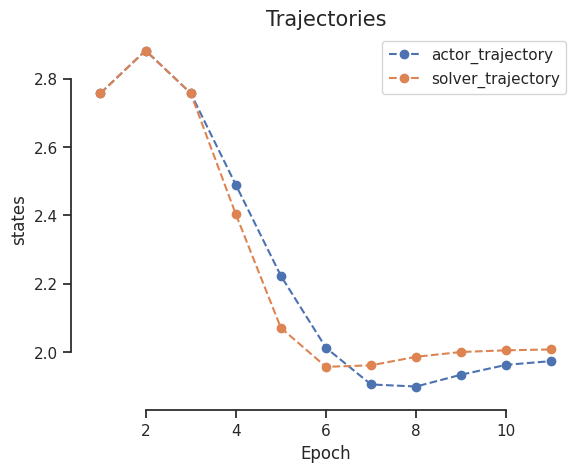

In [13]:
val = 95

traj, cost = compute_trajectory(np.array(states[val]), opt_actions[val])
traj_a, cost_a = compute_trajectory_actor(i_s[val])
print(f'Actual cost: {cost:.4f}')
print(f'Actor cost: {cost_a:.4f}')

plot("Trajectories", "states", traj_a[:,0], traj[:,0], legend = ["actor_trajectory", "solver_trajectory"])

#print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')

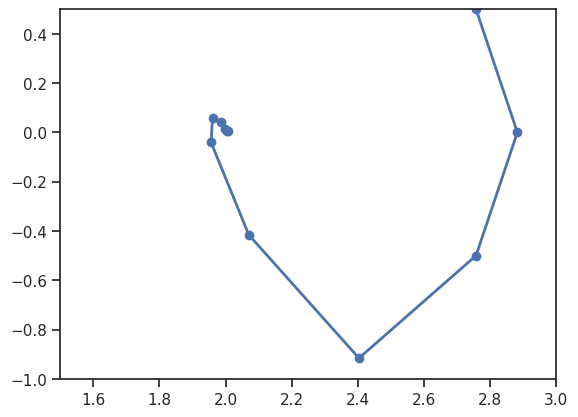

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_trajectory(trajectory, save_path='robot_trajectory.mp4', interval=100, xlim=(-5, 5), ylim=(-5, 5)):
    """
    Animate a given trajectory and save the animation as a video.

    Parameters:
    trajectory (numpy.ndarray): The trajectory to animate, shape (N, 2) where N is the number of time steps.
    save_path (str): Path to save the animation video.
    interval (int): Interval between frames in milliseconds.
    xlim (tuple): Limits for the x-axis.
    ylim (tuple): Limits for the y-axis.
    """
    fig, ax = plt.subplots()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    line, = ax.plot([], [], 'o-', lw=2)
    velocity_arrow = ax.quiver([], [], [], [], angles='xy', scale_units='xy', scale=1, color='r')

    def init():
        line.set_data([], [])
        velocity_arrow.set_offsets(np.array([[0, 0]]))
        return line, velocity_arrow

    def update(frame):
        # Update trajectory
        x = trajectory[:frame+1, 0]
        y = trajectory[:frame+1, 1]
        line.set_data(x, y)
        
        # Update velocity arrow
        vx = trajectory[frame, 1]
        velocity_arrow.set_offsets(np.array([[x[-1], y[-1]]]))
        velocity_arrow.set_UVC(vx, 0)  # Assuming velocity in the x direction only
        
        return line, velocity_arrow

    ani = animation.FuncAnimation(fig, update, frames=len(trajectory), init_func=init, blit=True, interval=interval)

    # Save the animation as a video file
    ani.save(save_path, writer='ffmpeg')

    # Display the animation
    plt.show()



# Animate the trajectory
animate_trajectory((traj), save_path='random_trajectory.mp4', interval=500, xlim=(1.5, 3), ylim=(-1, 0.5))
